# FloPy Creating Layered Quadtree Grids with GRIDGEN

FloPy has a module that can be used to drive the GRIDGEN program.  This notebook shows how it works.

The Flopy GRIDGEN module requires that the gridgen executable can be called using subprocess **(i.e., gridgen is in your path)**.

In [29]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

from flopy.utils.gridgen import Gridgen 

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.4
matplotlib version: 3.0.3
flopy version: 3.2.13


## Setup Base MODFLOW Grid

GRIDGEN works off of a base MODFLOW grid.  The following information defines the basegrid.

In [30]:
Lx = 100.
Ly = 100.
nlay = 2
nrow = 51
ncol = 51
delr = Lx / ncol
delc = Ly / nrow
h0 = 10
h1 = 5
top = h0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[1, :, :] = -10.

In [31]:
ms = flopy.modflow.Modflow(rotation=-20.)
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

## Create the Gridgen Object

In [32]:
model_ws = os.path.join('.', 'data')
g = Gridgen(dis, model_ws=model_ws)

## Add an Optional Active Domain
Cells outside of the active domain will be clipped and not numbered as part of the final grid.  If this step is not performed, then all cells will be included in the final grid.

In [33]:
# setup the active domain
adshp = os.path.join(model_ws, 'ad0')
adpoly = [[[(0, 0), (0, 60), (40, 80), (60, 0), (0, 0)]]]
# g.add_active_domain(adpoly, range(nlay))

## Refine the Grid

In [34]:
x = Lx * np.random.random(10)
y = Ly * np.random.random(10)
wells = list(zip(x, y))
g.add_refinement_features(wells, 'point', 3, range(nlay))
rf0shp = os.path.join(model_ws, 'rf0')

In [35]:
river = [[[(-20, 10), (60, 60)]]]
g.add_refinement_features(river, 'line', 3, range(nlay))
rf1shp = os.path.join(model_ws, 'rf1')

In [36]:
g.add_refinement_features(adpoly, 'polygon', 1, range(nlay))
rf2shp = os.path.join(model_ws, 'rf2')

## Plot the Gridgen Input

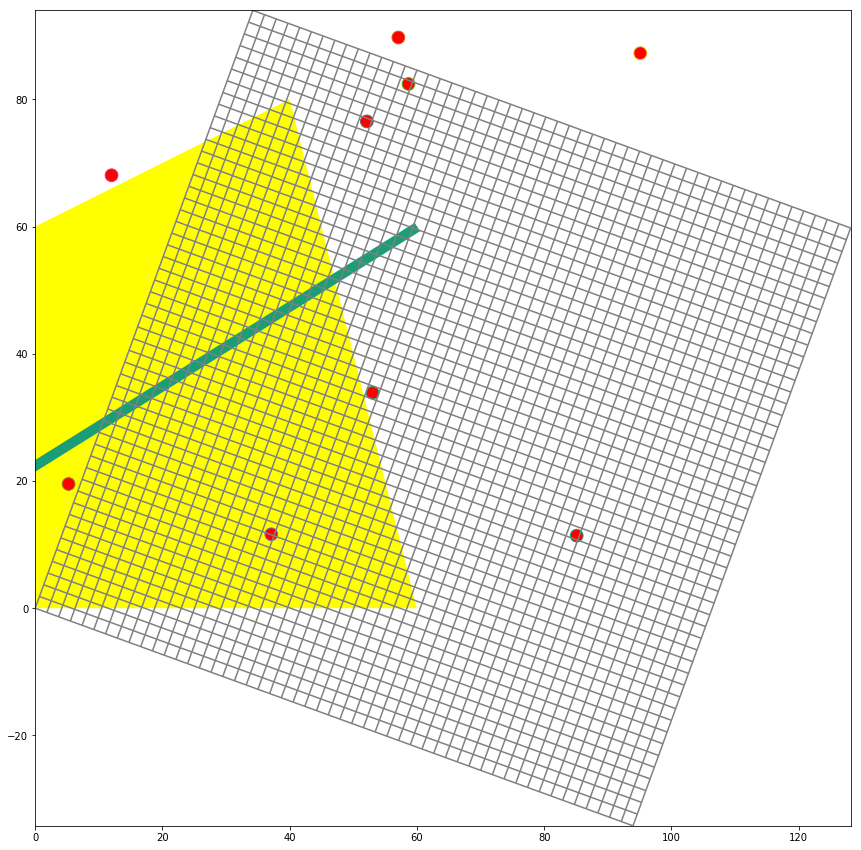

In [37]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none')
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1)

## Build the Grid

In [38]:
g.build(verbose=False)

## Plot the Grid

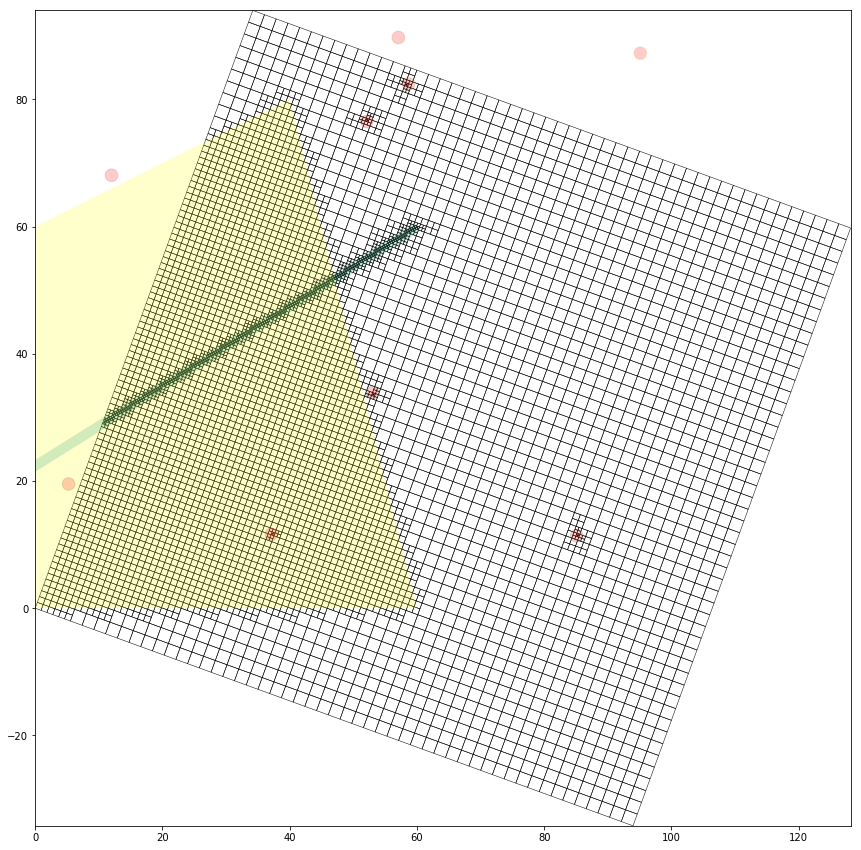

In [39]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none', alpha=0.2)
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10, alpha=0.2)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1, alpha=0.2)

## Create a Flopy ModflowDisu Object

In [40]:
mu = flopy.modflow.Modflow(model_ws=model_ws, modelname='mfusg')
disu = g.get_disu(mu)
disu.write_file()
# print(disu)

## Intersect Features with the Grid

In [41]:
adpoly_intersect = g.intersect(adpoly, 'polygon', 0)
print(adpoly_intersect.dtype.names)
print(adpoly_intersect)
print(adpoly_intersect.nodenumber)

('nodenumber', 'polyid', 'totalarea', 'SHAPEID')
[( 376, 0, 0.961169 , 0) ( 436, 0, 0.961169 , 0) ( 379, 0, 0.961169 , 0)
 ... (5955, 0, 0.0977309, 0) (5957, 0, 0.348072 , 0)
 (5958, 0, 0.0428516, 0)]
[ 376  436  379 ... 5955 5957 5958]


In [42]:
well_intersect = g.intersect(wells, 'point', 0)
print(well_intersect.dtype.names)
print(well_intersect)
print(well_intersect.nodenumber)

('nodenumber', 'pointid', 'SHAPEID')
[(2728, 0, 0) (3530, 1, 1) (4679, 3, 3) (  77, 5, 5) ( 318, 9, 9)]
[2728 3530 4679   77  318]


In [43]:
river_intersect = g.intersect(river, 'line', 0)
print(river_intersect.dtype.names)
# print(river_intersect)
# print(river_intersect.nodenumber)

('nodenumber', 'arcid', 'length', 'starting_distance', 'ending_distance', 'SHAPEID')


## Plot Intersected Features

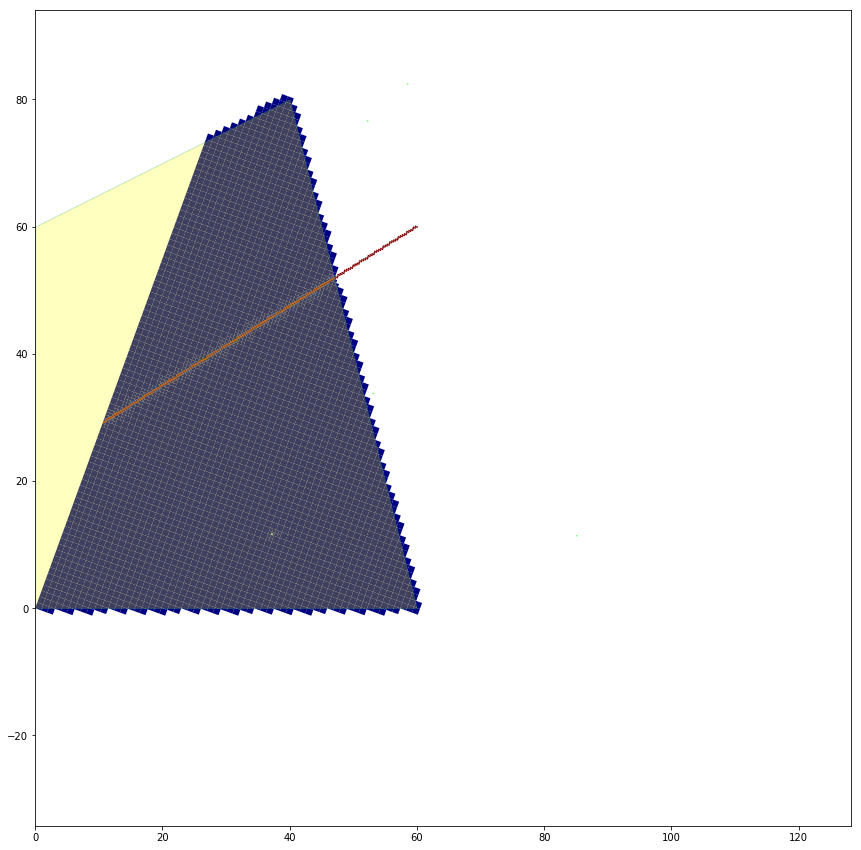

In [44]:
a = np.zeros((g.nodes), dtype=np.int)
a[adpoly_intersect.nodenumber] = 1
a[well_intersect.nodenumber] = 2
a[river_intersect.nodenumber] = 3
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, a=a, masked_values=[0], edgecolor='none', cmap='jet')
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', alpha=0.25)